In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
factor = pd.read_excel(r'C:\Users\20001009\factor_pricing_data.xlsx',sheet_name='factors (excess)')
factor.set_index('Date',inplace=True)

portfolio = pd.read_excel('factor_pricing_data.xlsx', 'assets (excess)').set_index("Date")

In [4]:
print('*** Factor Data ***')
display(factor.head())
print(' ')
print('*** Portfolio Data ***')
display(portfolio.head())

*** Factor Data ***


,MKT,SMB,HML,UMD
Date,,,,
1990-01-31,-0.0785,-0.0125,0.0085,-0.0327
1990-02-28,0.0111,0.0097,0.0064,-0.0054
1990-03-31,0.0183,0.0146,-0.0292,0.0180
1990-04-30,-0.0336,-0.0045,-0.0259,0.0239
1990-05-31,0.0842,-0.0256,-0.0383,0.0303


 
*** Portfolio Data ***


,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1990-01-31,-0.1000,-0.0441,-0.0618,-0.0487,-0.0862,-0.0182,-0.1396,-0.0592,-0.0700,-0.0793,-0.1035,-0.0789
1990-02-28,-0.0096,0.0456,0.0214,0.0253,0.0161,0.0345,-0.0092,-0.0036,0.0142,-0.0263,0.0175,0.0238
1990-03-31,0.0390,0.0226,0.0396,-0.0121,0.0158,0.0383,0.0354,-0.0139,0.0447,0.0321,-0.0220,0.0128
1990-04-30,-0.0096,-0.0473,-0.0365,-0.0423,-0.0285,-0.0271,-0.0415,-0.0620,-0.0279,-0.0040,-0.0492,-0.0290
1990-05-31,0.0836,0.0708,0.0707,0.0535,0.0825,0.1188,0.0870,0.0475,0.1097,0.1209,0.0858,0.0820


In [5]:
def performanceMetrics(returns):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean()  * 12
    metrics['Vol'] = returns.std() * np.sqrt(12)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(12)
    metrics['Var(0.05)'] = returns.quantile(.05)

    return metrics

metrics = performanceMetrics(factor)
metrics

,Mean,Vol,Sharpe,Var(0.05)
MKT,0.084331,0.151860,0.555321,-0.076485
SMB,0.012124,0.109577,0.110641,-0.042925
HML,0.018235,0.111001,0.164279,-0.041590
UMD,0.057374,0.163416,0.351094,-0.071160


Below we can find a plot of the cumulative returns of our factors:


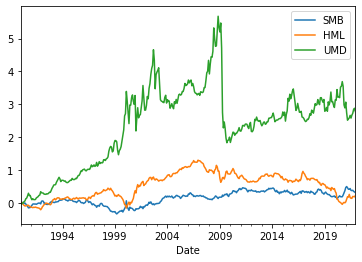

In [6]:
factorsCumReturn = (1+factor).cumprod() - 1


print("Below we can find a plot of the cumulative returns of our factors:")
factorsCumReturn[["SMB", "HML", "UMD"]].loc[:"2021"].plot()
plt.show()

In [7]:
corr=factor.corr()
corr

,MKT,SMB,HML,UMD
MKT,1.000000,0.242287,-0.131518,-0.279605
SMB,0.242287,1.000000,-0.220609,0.007414
HML,-0.131518,-0.220609,1.000000,-0.230405
UMD,-0.279605,0.007414,-0.230405,1.000000


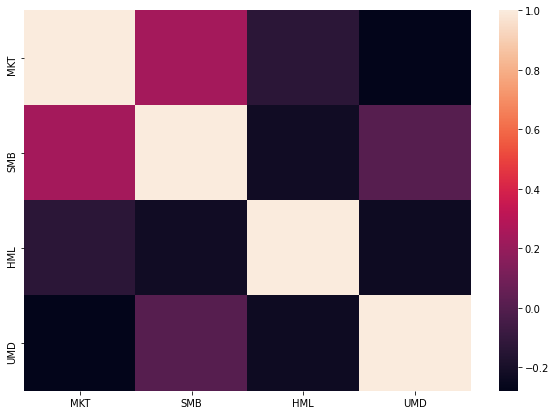

In [8]:
#Visualize Correaltion Matrix
plt.figure(figsize = (10,7))
hm = sns.heatmap(corr)
plt.show()

,Mean,Vol,Sharpe,Var
NoDur,0.085781,0.131829,0.650702,-0.057325
Durbl,0.106454,0.270225,0.393945,-0.112125
Manuf,0.101038,0.184678,0.547106,-0.084080
Enrgy,0.087028,0.220138,0.395333,-0.095495
Chems,0.085880,0.147866,0.580798,-0.071560
BusEq,0.124859,0.235254,0.530740,-0.111065
Telcm,0.054792,0.175183,0.312769,-0.089795
Utils,0.075019,0.138273,0.542541,-0.062895
Shops,0.096755,0.160510,0.602795,-0.071895
Hlth,0.097002,0.153318,0.632684,-0.072780


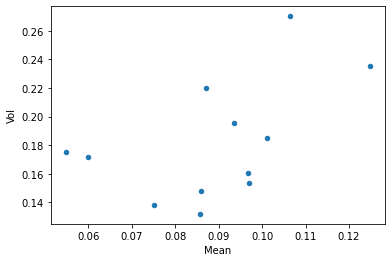

In [9]:
def performanceMetrics(returns):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean()  * 12
    metrics['Vol'] = returns.std() * np.sqrt(12)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(12)
    metrics['Var'] = returns.quantile(.05)

    return metrics

metrics = performanceMetrics(portfolio)
display(metrics)

metrics.plot.scatter('Mean', 'Vol')
plt.show()


<font size=5>CAPM</font>

In [20]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [22]:
coef_table = get_ols_metrics(factor['MKT'], portfolio, annualization=1, ignorenan=True)
display(coef_table)

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,0.002713,0.631107,0.528530,0.011327,0.103837
Durbl,-0.000694,1.361055,0.585043,0.006518,-0.013807
Manuf,0.000666,1.103314,0.823107,0.007631,0.029712
Enrgy,0.001318,0.844363,0.339277,0.008589,0.025525
Chems,0.001771,0.766347,0.619440,0.009339,0.067261
BusEq,0.001022,1.335217,0.742874,0.007793,0.029665
Telcm,-0.001928,0.924102,0.641718,0.004941,-0.063701
Utils,0.003377,0.409096,0.201866,0.015281,0.094688
Shops,0.001778,0.894385,0.716031,0.009015,0.071989
Hlth,0.003014,0.721341,0.510481,0.011206,0.097339


If CAPM were true, alpha would equal 0 in terms of the population, then the information ratio would be 0 as well. And all Treynor ratios should be equal.

In [23]:
# To calculate the Mean-Absolute-Error

mean_abs_err = coef_table.alpha.mean()
print('Mean Absolute Error: {:,.4f}'.format(mean_abs_err * 12))

Mean Absolute Error: 0.0108


<AxesSubplot:xlabel='MKT', ylabel='Mean'>

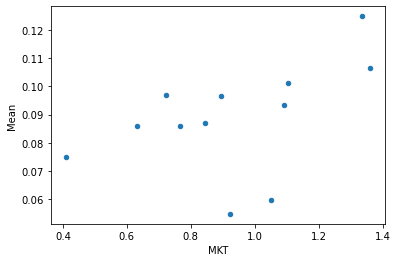

In [25]:
pd.concat([metrics[['Mean']], coef_table[['MKT']]], axis = 1).plot.scatter('MKT', 'Mean')

<font size=5>A multifactor model</font>

In [29]:
coef_table = get_ols_metrics(factor, portfolio, annualization=1, ignorenan=True)
display(coef_table)

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,0.002146,0.692980,-0.224157,0.180900,0.017596,0.592773,0.088364
Durbl,0.000244,1.282958,0.225710,0.389508,-0.252858,0.645081,0.005252
Manuf,0.000600,1.089994,0.098580,0.267399,-0.072425,0.856889,0.029759
Enrgy,-0.000205,0.894541,0.099916,0.664253,0.012596,0.444036,-0.004320
Chems,0.001351,0.812860,-0.170000,0.211870,-0.011883,0.668325,0.054952
BusEq,0.003264,1.206822,0.183458,-0.643065,-0.114672,0.841916,0.120880
Telcm,-0.001494,0.932912,-0.167901,-0.036368,-0.056660,0.654467,-0.050269
Utils,0.001824,0.513189,-0.219278,0.311550,0.119010,0.303930,0.054777
Shops,0.001888,0.894783,-0.031607,-0.006371,-0.015008,0.716681,0.076556
Hlth,0.002847,0.760984,-0.195943,-0.151362,0.066264,0.542197,0.095063


In [30]:
mean_abs_err = coef_table.alpha.mean()
print('Mean Absolute Error: {:,.4f}'.format(mean_abs_err * 12))

Mean Absolute Error: 0.0091
